### IMPORTANT: Change BASE_DATASET_FOLDER with the root dataset folder with the images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Change BASE_DATASET_FOLDER according to folder with dataset
BASE_DATASET_FOLDER = "/content/drive/My Drive/Colab Notebooks/Tryolabs-CV-Interview/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The project
The problem to analyze is the [Kaggle plant seedlings classification](https://www.kaggle.com/c/plant-seedlings-classification).

##  Competition goal
The goal is to differentiate a weed from a crop seedling in order to perform site-specific weed control.

## Dataset
The [database of images](https://arxiv.org/abs/1711.05458) has approximately 960 unique plants belonging to 12 species at several growth stages. It comprises annotated RGB images with a physical resolution of roughly 10 pixels per mm.

## Kernel structure
The following is a summary of the kernel main structure.

### 1. Kagglers challenges and discussions
- Review other kagglers kernels to better understand the competition challenges.
- Review the competition discussion forum for interesting conversation threads.
- Generate insights from the information gathering.

For further information please refer [here](https://github.com/jprussoibanez/plant-seedlings-classification/blob/master/docs/kagglers_discussions.md).

### 2. Libraries and settings
- This section has available settings to configure the model and its training parameters.

For further information please refer [here](https://github.com/jprussoibanez/plant-seedlings-classification/blob/master/docs/settings.md).

### 3. Data analysis
- Data exploration and descriptive analysis to determine dataset shape and distribution.
- Use of t-SNE to reduce dimensionality for data visualization.

### 4. Pre-processing
- Class weights calculation to balance the dataset distribution.
- Image segmentation to mask image background.
- Data augmentation to increase the images dataset.

### 5. Processing
- Use of transfer learning with different pre-trained models like Resnet50 and InceptionV3. Other pre-trained models can be easily added.
- Use of custom CNN with multiple layers.
- FNN as the last layer classifier.

### 6. Generate prediction file
- Generate prediction file with Kaggle competition format.

# 1. Kagglers challenges and discussions
The first step is to review the discussion forum for this competition to better discover the challenges and approaches in solving the problem.

For a detailed discussion please refer [here](https://github.com/jprussoibanez/plant-seedlings-classification/blob/master/docs/kagglers_discussions.md).


# 2. Libraries and settings

## 2.1 Libraries

This are the main libraries for coding the kernel:
1. [tensorflow](https://www.tensorflow.org/) with [keras](https://keras.io/) for managing the deep learning models. Using latest tensorflow 2.0 and tensorflow keras on google colab.
2. [sckilit-learn](https://scikit-learn.org/), [numpy](https://numpy.org/), [pandas](https://pandas.pydata.org/) with [seaborn](https://seaborn.pydata.org/) for data manipulation, analysis and visualization.
3. [TQDM](https://github.com/tqdm/tqdm) for progress bar visualization on processing.
4. [opencv](https://pypi.org/project/opencv-python/) for image processing.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd

# Keras
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, xception
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, Input, Activation, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

import os

# Helpers
from tqdm import tqdm
from enum import Enum

# Image processing
import cv2

# Image plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

TensorFlow 2.x selected.


## 2.2 Global variables

This are the global variables use to setup the configuration for the models.

In [0]:
# Global settings
TRAIN_DATASET_FOLDER = os.path.join(BASE_DATASET_FOLDER, "train")
TEST_DATASET_FOLDER = os.path.join(BASE_DATASET_FOLDER, "test")
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3

TSNE_VISUALIZATION = False

# Data augmentation settings
rotation_range = 250      
zoom_range = 0.5         
width_shift_range = 0.5  
height_shift_range = 0.5 
horizontal_flip = True   
vertical_flip = True

# Training settings
batch_size = 30
epochs = 500
steps_per_epoch = 50
patience = 8

class TrainingNetwork(Enum):
    CUSTOM_CNN = 1    # Custom multi-layer convolutional network with 3 layers
    RESNET_50 = 2     # Pre-trained Resnet50
    INCEPTION_V3 = 3  # Pre-trained InceptionV3
    XCEPTION = 4      # Pre-trained Xception

# Choose model to train
NETWORK_TO_TRAIN = TrainingNetwork.XCEPTION

# 3. Data analysis

The first and the most important task in solving a problem with Machine Learning is to analyze the dataset before proceeding with any algorithms. This is important in order to understand the complexity of the dataset which will eventually help in designing the algorithm.

## 3.1 Load data and images

The first step is to load the images and data from the datasets through panda and dataframes.

In [0]:
def get_species_groups():
    """ 
    Get the species group from the folders' name on the dataset. 
  
    @Returns: 
        array: Array of species groups to train.
    """
    return [
      'Black-grass',
      'Charlock',
      'Cleavers',
      'Common Chickweed',
      'Common wheat',
      'Fat Hen',
      'Loose Silky-bent',
      'Maize',
      'Scentless Mayweed',
      'Shepherds Purse',
      'Small-flowered Cranesbill',
      'Sugar beet'
    ]

def read_train_data(species_groups):
    """ 
    Read the train species data from the datasets folder. 
  
    @Parameters:
        species_groups (array): Array of species groups to train.
  
    @Returns: 
        dataframe: Dataframe with the filepath, filename and species group category for each species image.
    """
    train = []
    for _, species in tqdm(enumerate(species_groups), total=len(species_groups)):
        for file in os.listdir(os.path.join(TRAIN_DATASET_FOLDER, species)):
            train.append([f'{TRAIN_DATASET_FOLDER}/{species}/{file}', file, species])
    
    train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species'])
    
    return train_df

def read_image(image_file_path, image_width, image_height):
    """ 
    Read and transform image according to widht, height and channels.
  
    @Parameters:
        image_file_path(string): Image file path to read.
        image_width (int): Image width to resize.
        image_height (int): Image height to resize.
  
    @Returns: 
        array: Array of loaded images resized to image_width and image_height.
    """
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_width, image_height))
    
    return image

def load_images(filepaths, image_width, image_height, preprocess_function = lambda x: x):
    images =[]
    for filepath in tqdm(filepaths, total=len(filepaths)):
      images.append(preprocess_function(read_image(filepath, image_width, image_height)))

    return images
    
def load_species_images(species_data, image_width, image_height, preprocess_function = lambda x: x):
    """ 
    Load images to input features on neural network model and do one hot encode for labels.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
        image_width (int): Image width to resize.
        image_height (int): Image height to resize.
       
    @Returns: 
        species_X (array): Array of images on the data.
        species_Y (array): One hot encode for labels.
    """ 
    species_X = load_images(species_data['filepath'],image_width, image_height, preprocess_function)
    species_Y = pd.get_dummies(species_data['species'], drop_first = False)
    
    return np.stack(species_X), species_Y

def show_grid_multiple_sample(species_data, species_groups):
    """ 
    Plot sample images from each species group.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
        species_groups (array): Array with species group.
       
    @Returns: None
    Plots grid with number_of_samples images with image_size for each species_group
    """
    number_of_samples = 8
    image_size = 100
    
    number_of_species = len(species_groups) 
    fig, axes = plt.subplots(nrows = number_of_species, ncols = number_of_samples + 1, figsize = (20, 28), gridspec_kw = {'wspace': 0.05, 'hspace': 0})
 
    for species_id, species in enumerate(species_groups):
        samples_species_filepath = species_data[species_data['species'] == species]['filepath'].sample(number_of_samples)
        ax = axes[species_id, 0]
        ax.axis('off')
        ax.text(0.5, 0.5, species, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10, transform = ax.transAxes)
        for sample_id, sample_species_filepath in enumerate(samples_species_filepath):
            image = read_image(sample_species_filepath, image_size, image_size)
            ax = axes[species_id, sample_id + 1]
            ax.axis('off')
            ax.imshow(image)
            
    plt.show()

def show_grid_one_sample(species_data, species_groups):
    """ 
    Plot one sample image from each species group.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
        species_groups (array): Array with species group.
       
    @Returns: None
    Plots one sample image with image_size for each species_group
    """
    image_size = 100
    number_of_species = len(species_groups)
    
    fig, axes = plt.subplots(nrows = 2, ncols = int(number_of_species / 2), figsize = (20, 8), gridspec_kw = {'wspace': 0.05, 'hspace': 0.05})
    axes = axes.flatten()
    
    for group_id, (group_name, group) in enumerate(species_data.groupby('species')):
        image = read_image(group.sample(1).iloc[0]['filepath'], image_size, image_size)
        axes[group_id].axis('off')
        axes[group_id].set_title(group_name)
        axes[group_id].imshow(image)
            
    plt.show()
    
def show_species_distribution(species_data):
    """ 
    Plot species distribution.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
       
    @Returns: None
    Plots species distribution on an histogram and pie chart.
    """
    species_groups = species_data['species'].unique()
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    colors_palette = sns.husl_palette(len(species_groups), h = 0.01, l = 0.6, s = .2)
    explode_chart = np.full(len(species_groups), 0.1)
    
    species_data.groupby('species').size().plot.bar(
        subplots = True, ax = axes[0], stacked = True, title = 'Species distribution', label = "", color = colors_palette
    )
     
    species_data['species'].value_counts().plot.pie(
        subplots = True, ax = axes[1], autopct = '%.2f', title = 'Species distribution', label = "", colors = colors_palette, explode = explode_chart
    )
    
    plt.show()
    
class TSNE_dimension(Enum):
    TWO = 1
    THREE = 2
    
def apply_PCA(images, n_components = 100):
    pca = PCA(n_components = n_components)
    pca_result = pca.fit_transform(images)
    
    return pca_result

def apply_TSNE(images, n_components = 2, perplexity = 100):
    tsne = TSNE(n_components = n_components, perplexity = perplexity)
    tsne_result = tsne.fit_transform(images)
    
    return tsne_result

def plot_TSNE_with_PCA(images, image_labels, dimension = TSNE_dimension.TWO):
    pca_results = apply_PCA(images)
    n_components = (2 if dimension == TSNE_dimension.TWO else 3)
    tsne_result = apply_TSNE(pca_results, n_components)
    plot_TSNE_results(tsne_result, image_labels, dimension = TSNE_dimension.TWO)

def plot_TSNE_results(tsne_result, image_labels, dimension = TSNE_dimension.TWO):
    df = pd.DataFrame(tsne_result).assign(label = image_labels)
    plt.figure(figsize=(10,10))
    if dimension == TSNE_dimension.TWO:
        sns.scatterplot(x = 0, y = 1, hue = 'label', data = df);
    else:
        fig = px.scatter_3d(df, x = 0, y = 1, z = 2, color = 'label')
        fig.show();

### 3.1.1 Load data

Load data from the datasets image folders.

In [5]:
species_groups = get_species_groups()
print(f"This are the groups to be loaded and trained: {species_groups}")

This are the groups to be loaded and trained: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [6]:
all_train_df = read_train_data(species_groups)
all_train_df.sample(4)

100%|██████████| 12/12 [00:01<00:00, 11.06it/s]


,filepath,file,species
3098,/content/drive/My Drive/Colab Notebooks/Tryola...,3b6bc2e4c.png,Maize
2451,/content/drive/My Drive/Colab Notebooks/Tryola...,05067feb7.png,Loose Silky-bent
202,/content/drive/My Drive/Colab Notebooks/Tryola...,e5a6e8ebc.png,Black-grass
4630,/content/drive/My Drive/Colab Notebooks/Tryola...,5f69d5659.png,Sugar beet


### 3.1.2 Descriptive analysis

The descriptive analysis has the following steps:
1. Visualize sample images by species group.
2. Analyze species group distribution.
3. Apply dimensionality reduction through PCA & t-SNE.

#### 3.1.2.1 Sample images by species group

The sample visualization shows the difficulty to distinguish between different weeds species groups even for a human eye.

In [7]:
show_grid_multiple_sample(all_train_df, species_groups)

Output hidden; open in https://colab.research.google.com to view.

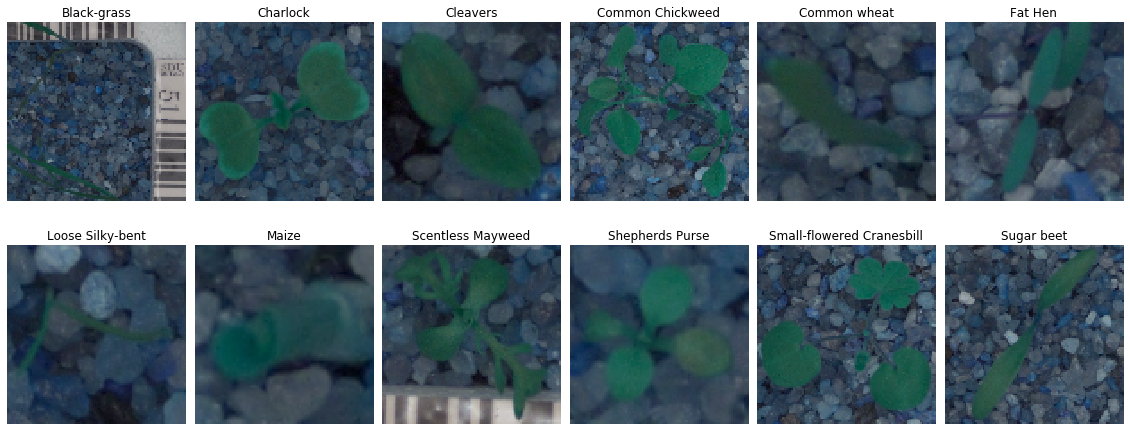

In [8]:
show_grid_one_sample(all_train_df, species_groups)

#### 3.1.2.2 Species group distribution

The distribution visualization demonstrates an imbalance in the dataset weed types or groups.

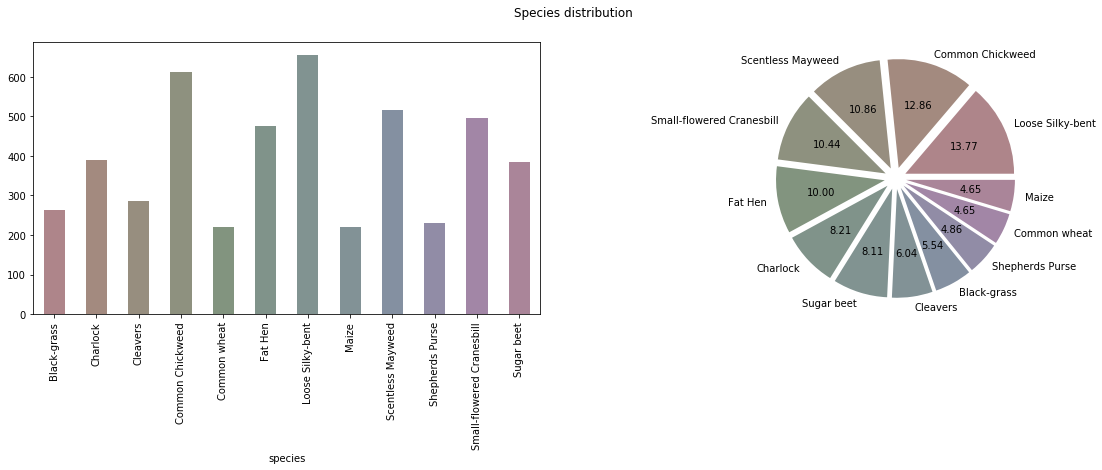

In [9]:
show_species_distribution(all_train_df)

#### 3.1.2.3 PCA & TSNE

The PCA and t-SNE can be applied for dimensionality reduction to images on 2D and 3D. There is no clear clustering or similarity on the lower dimensions (at least before applying the pre-processing segmentation process).

NOTE: The number of sample images are reduced to 500 images to avoid long loading times.

In [0]:
if TSNE_VISUALIZATION:
    sample_df = all_train_df.sample(500)
    sample_images, _ = load_species_images(sample_df, IMAGE_WIDTH, IMAGE_HEIGHT)

In [0]:
if TSNE_VISUALIZATION:
    flatten_images = [image.flatten() for image in sample_images]
    pca_results = apply_PCA(flatten_images)
    tsne_results = apply_TSNE(pca_results)
    plot_TSNE_results(tsne_results, sample_df['species'].values)

In [0]:
if TSNE_VISUALIZATION:
    tsne_results = apply_TSNE(pca_results, n_components = 3)
    plot_TSNE_results(tsne_results, sample_df['species'].values, TSNE_dimension.THREE)

## 3.2 Conclusions

From the descriptive analysis some of the conclusions are:
- There is an imbalance on the dataset which should be handled to avoid training biases.
- There are not much images for training deep learning models so we should use data augmentation to increase the dataset.
- All weed images have backgrounds that we should be removed in order to improve weed recognition.
- There is no clear clustering on lower dimensions before pre-processing.

# 4. Pre-processing

This are the principal concerns that should be addressed on the pre-processing from the data analysis:

1. Balance the dataset to avoid biases on imbalance weed types.
2. Use image segmentation to remove background as to focus on weed recognition.
3. Apply data augmentation to increase the data available for training.

## 4.1 Balance dataset

The class weights computation allows to handle unbalance data distribution by weighting the class importance on training.

Other ways of balancing the dataset are oversampling and undersampling with methods like SMOTE and ADASYN.

In [0]:
def compute_class_weights(data_groups) :
    return dict(enumerate(compute_class_weight("balanced", np.unique(data_groups), data_groups)))

In [14]:
class_weights = compute_class_weights(all_train_df['species'])
print(f"This are the class weights that will be use for training to balance the dataset: {class_weights}")

This are the class weights that will be use for training to balance the dataset: {0: 1.5050697084917617, 1: 1.014957264957265, 2: 1.3792102206736354, 3: 0.6478450627386798, 4: 1.7911010558069382, 5: 0.8333333333333334, 6: 0.605249745158002, 7: 1.7911010558069382, 8: 0.7671188630490956, 9: 1.7135642135642135, 10: 0.7980510752688172, 11: 1.0281385281385282}


## 4.2 Segmentation
The segmentation process masks the main object of analysis by removing all unnecessary background.

In this section the segmentation operation is applied to a single image with the following steps:

1. Mask creation 
  1. Change the color space from RGB to HSV. This is an easier space to define color ranges.
  2. Define the color range for green (common weed color).
  3. Define the most common shape for weeds. For this case close ellipses.
  4. Apply the morphology transformation to identify the weeds within the color range and shape. 
2. Apply mask to remove background

Further information can be found on openCV documentation on [colorspaces](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) and [Morphological Transformations](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def create_image_tranformation(image):
    masked_image = create_mask_for_plant(image)
    segmented_image = segment_plant(image)
    
    return masked_image, segmented_image

def load_species_images_with_segmentation(species_data, image_width, image_height):
    return load_species_images(species_data, image_width, image_height, segment_plant)

def plot_image_transformation(original_image, masked_image, segmented_image):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 10))
    axs[0].imshow(original_image)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(masked_image)
    axs[1].axis('off')
    axs[1].set_title('Masked image')
    axs[2].imshow(segmented_image)
    axs[2].set_title('Segmented image')
    axs[2].axis('off')

100%|██████████| 1/1 [00:00<00:00, 80.44it/s]


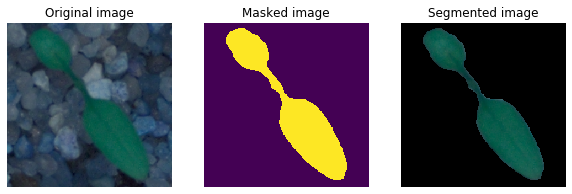

In [16]:
sample_image, _ = load_species_images(all_train_df.sample(1), IMAGE_WIDTH, IMAGE_HEIGHT)
masked_image, segmented_image = create_image_tranformation(sample_image[0])
plot_image_transformation(sample_image[0], masked_image, segmented_image)

Applying t-SNE again on the same sample images but now with segmentation.

In [0]:
if TSNE_VISUALIZATION:
    sample_images, _ = load_species_images_with_segmentation(sample_df, IMAGE_WIDTH, IMAGE_HEIGHT)
    flatten_images = [image.flatten() for image in sample_images]
    plot_TSNE_with_PCA(flatten_images, sample_df['species'].values, TSNE_dimension.TWO)

## 4.2 Data augmentation

For the data augmentation we can use keras preprocessing library [ImageDataGenerator](https://keras.io/preprocessing/image/).

The class can generate batches of tensor image data with real-time data augmentation while training the model. This are the transformations apply to augment the data:
- Random rotations within a range define by rotation_range.
- Random zooms within a range define by zoom_range.
- Random width shifts define by width_shift_range.
- Random heigh shifts define by height_shift_range.
- Random horizontal flips.
- Random vertical flips.

NOTE: All this variables can be configured at the beginning of the notebook.

This section will show some random transformations on a number of sample images.

In [0]:
def create_image_data_generator(
    rotation_range,  
    zoom_range,
    width_shift_range, 
    height_shift_range, 
    horizontal_flip,
    vertical_flip
):
    return ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = rotation_range,
        zoom_range = zoom_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip
    )
    
def show_augmentation_row(original_image, images_iterator, number_of_augmentations, axes):   
    axes[0].axis('off')
    axes[0].set_title('Original image')
    axes[0].imshow(original_image)
    
    for image_number in range(number_of_augmentations):
        image = images_iterator.next()
        axes[image_number + 1].axis('off')
        axes[image_number + 1].set_title('Augmented image')
        axes[image_number + 1].imshow(image[0].astype(np.uint8))

def show_grid_with_augmented_images(number_of_samples, number_of_augmentations, image_data_generator):   
    fig, axes = plt.subplots(nrows = number_of_samples, ncols = number_of_augmentations + 1, figsize = (30, 4 * number_of_samples), gridspec_kw = {'wspace': 0.05, 'hspace': 0.05})
    fig.suptitle('Sample augmented images', fontsize=16)
    
    sample_images, _ = load_species_images_with_segmentation(all_train_df.sample(number_of_samples), IMAGE_WIDTH, IMAGE_HEIGHT)
    for sample_id, sample_image in enumerate(sample_images):
        images_iterator = image_data_generator.flow(np.expand_dims(sample_image, axis=0), None, 1)
        show_augmentation_row(sample_image, images_iterator, number_of_augmentations, axes[sample_id])
    
    plt.show()

In [0]:
image_data_generator = create_image_data_generator(
    rotation_range = 250,    
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
)

100%|██████████| 5/5 [00:00<00:00, 143.72it/s]


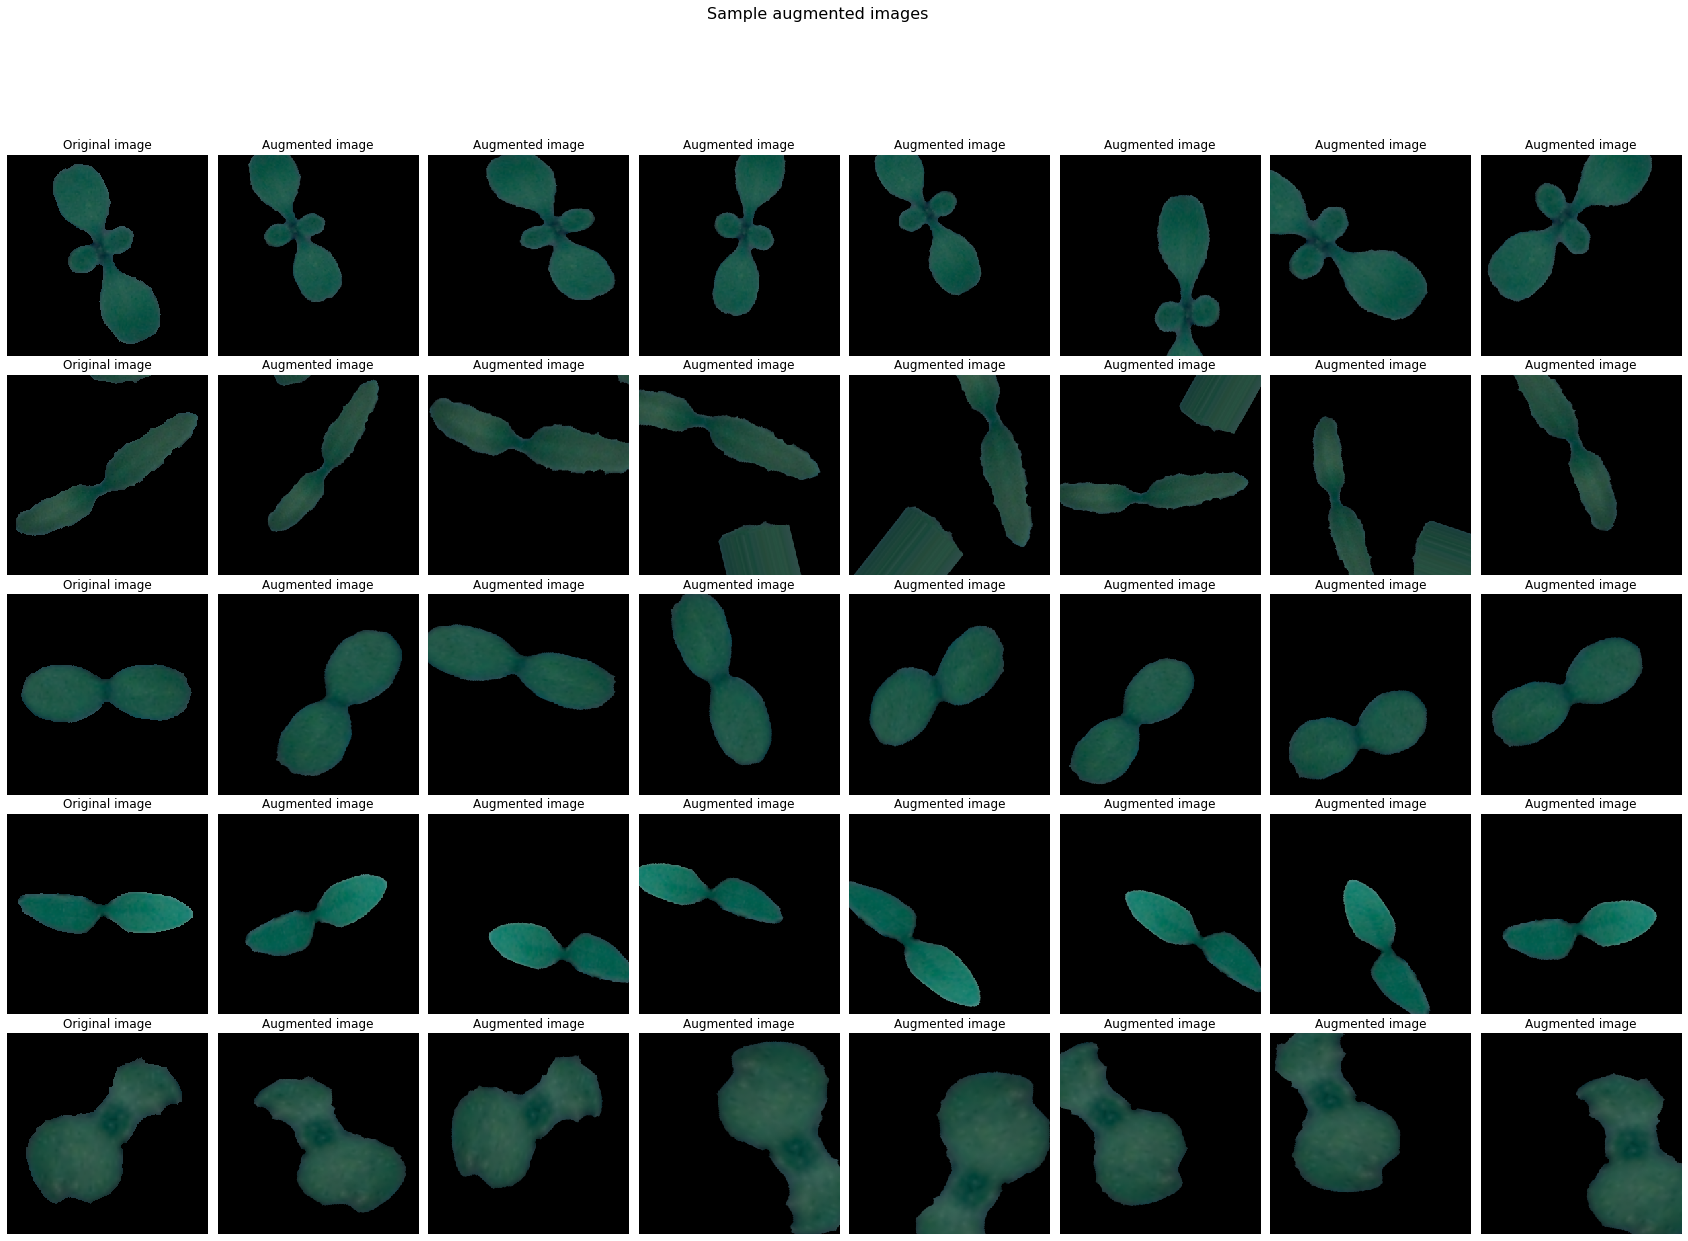

In [20]:
show_grid_with_augmented_images(number_of_samples = 5, number_of_augmentations = 7, image_data_generator = image_data_generator)

# 5. Processing

This section describes the model architecture and the training process. This are the following architectures use for training:

- Pre-trained models: This models are use for transfer learning by reusing their weights/layers and retraining only the classifier for the specific domain. 
- Custom CNN: This is a multi-layer CNN using batch normalization and regularization.

Also different metrics are use to validate the model like accuracy, recall, f1-score and the confusion matrix.

The training set is divided in training (80%), validation (10%) and test sets (10%).

The NETWORK_TO_TRAIN parameter (at the beginning of the notebook) can be used to select the model to train:

- CUSTOM_CNN: Custom multi-layer CNN with FNN classifier.
- RESNET_50: Resnet_50 model with FNN classifier.
- INCEPTION_V3: InceptionV3 model with FNN classifier.

It should be easy to add additional pre-trained models if desired.

Some additional improvements, not implemented on this notebook yet, are:

- Fine tune pre-trained models by unfreezing and training the last layers on the CNN.
- Use hyperparameters optimization using some library like hyperopt to optimize model parameters.
- Use more classifiers like XGBoost, SVM, etc. instead of just the FNN.
- Ensemble models to improve performance by combining different models.
- Use cross-validation to better evaluate the estimator performance.

In [0]:
number_output_classes = len(get_species_groups())

In [0]:
class TrainingModel:
    accuracy_metric = {
        'training': {
            'metric': 'accuracy',
            'label': 'Accuracy'
        },
        'validation': {
            'metric': 'val_accuracy',
            'label': 'Validation accuracy'
        }
    }
    loss_metric = {
        'training': {
            'metric': 'loss',
            'label': 'Loss'
        },
        'validation': {
            'metric': 'val_loss',
            'label': 'Validation loss'
        }
    }
    
    def __init__(self, image_data_generator, base_model, classifier_model):
        self.image_data_generator = image_data_generator
        self.optimizer = Adam(lr=1e-3)
        self.loss = 'categorical_crossentropy'
        self.metrics = [TrainingModel.accuracy_metric['training']['metric']]
        self.training_results = None
        self.training_model = self.create_model(base_model, classifier_model)
        self.species_names = get_species_groups()
    
    def __del__(self):
        del self.image_data_generator
        del self.training_model
        del self.training_results
    
    def create_model(self, base_model, classifier_model):
        model = Sequential(name = "Species-Prediction-CNN")
        model.add(base_model)
        model.add(classifier_model)

        model.compile(optimizer = self.optimizer, loss = self.loss, metrics = self.metrics)  
        model.summary()

        return model

    def train_model(
        self,
        train_X,
        train_y,
        validation_data_X,
        validation_data_y,
        batch_size,
        epochs,
        steps_per_epoch,
        patience,
        class_weights
    ):
    
        self.image_data_generator.fit(train_X)
        earlystopper = EarlyStopping(monitor = 'loss', patience = patience, verbose = 1, restore_best_weights = True)
        lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 1e-5, patience = patience, verbose = 1)

        self.training_results = self.training_model.fit(
            self.image_data_generator.flow(train_X, train_y, batch_size),
            epochs = epochs,
            validation_data = [validation_data_X, validation_data_y],
            steps_per_epoch = steps_per_epoch,
            callbacks = [earlystopper, lr_reduce],
            class_weight = class_weights
        )
        
    def predict(self, x):
        return self.training_model.predict(x, verbose = 1)
    
    def predict_species_class(self, x):
        return np.argmax(self.predict(x), axis = 1)
    
    def predict_species_name(self, x):
        return [self.species_names[species_class] for species_class in self.predict_species_class(x)]

    def eval_model(self, test_X, test_Y, field_name = 'species'):
        """
        Model evaluation: plots, classification report
        @param training: model training history
        @param model: trained model
        @param test_X: features 
        @param test_y: labels
        @param field_name: label name to display on plots
        """        
        test_pred = self.training_model.predict(test_X)
 
        self.plot_metrics(test_X, test_Y, test_pred, field_name)
        
        self.plot_classification_report(test_X, test_Y, test_pred)
        
        self.plot_confusion_matrix(test_Y, test_pred)
    
    def plot_metrics(self, test_X, test_y, test_pred, field_name = 'species'):
        fig, axes = plt.subplots(1, 3, figsize = (20, 7))
        
        self.plot_metric(TrainingModel.accuracy_metric, axes[0], field_name)
        self.plot_metric(TrainingModel.loss_metric, axes[1], field_name)
        self.plot_accuracy_by_species_group(test_X, test_y, test_pred, axes[2], field_name)

        plt.tight_layout()
        plt.show()
        
    def plot_metric(self, metric, axes, field_name):
        axes.plot(self.training_results.history[metric['training']['metric']], label = metric['training']['label'])
        axes.plot(self.training_results.history[metric['validation']['metric']], label = metric['validation']['label'])
        axes.set_title(f'{field_name} {metric["training"]["metric"]}')
        axes.set_xlabel('Epoch')
        axes.set_ylabel(metric['training']['label'])
        axes.legend()
 
    def plot_accuracy_by_species_group(self, test_X, test_y, test_pred, axes, field_name):
        acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum() / test_y.sum()
        acc_by_subspecies.plot.bar(title = f'Accuracy by {field_name}', ax = axes)
        plt.ylabel('Accuracy')
    
    def plot_classification_report(self, test_X, test_y, test_pred):
        print("Classification report")
        test_pred = np.argmax(test_pred, axis = 1)
        test_truth = np.argmax(test_y.values, axis = 1)

        print(metrics.classification_report(test_truth, test_pred, target_names = test_y.columns, zero_division = True))

        test_res = self.training_model.evaluate(test_X, test_y.values, verbose = 0)
        print('Loss function: %s, accuracy:' % test_res[0], test_res[1])
        
    def plot_confusion_matrix(self, test_Y, test_pred):
        cnf_matrix = metrics.confusion_matrix(np.argmax(test_Y.values, axis = 1), np.argmax(test_pred, axis = 1))

        abbreviation = ['Bg', 'Ch', 'Cl', 'CC', 'Cw', 'FH', 'LSb', 'M', 'SM', 'SP', 'SfC', 'Sb']
        pd.DataFrame({'class': self.species_names, 'abbreviation': abbreviation})

        fig, ax = plt.subplots(1, 1, figsize = (10, 10))
        ax = sns.heatmap(cnf_matrix, ax = ax, cmap = plt.cm.Greens, annot = True)
        ax.set_xticklabels(abbreviation)
        ax.set_yticklabels(abbreviation)
        plt.title('Confusion matrix of test set')
        plt.ylabel('True species')
        plt.xlabel('Predicted species')
        
        plt.show();

In [0]:
def split(data):
    train_data, validation_data = train_test_split(data, test_size = 0.2, shuffle = True)
    validation_data, test_data = train_test_split(validation_data, test_size = 0.5, shuffle = True)

    return (train_data, validation_data, test_data)
        
def create_CNN_classifier_global_max_pooling(batch_normalization = False, dropout = False, kernel_regularizer = None):
    model = Sequential(name = 'GlobalMaxPooling-FNN-classifier')
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1024, kernel_regularizer = kernel_regularizer, name = "dense1", activation = 'relu'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(1024, kernel_regularizer = kernel_regularizer, name = "dense2", activation = 'relu'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(number_output_classes, activation = 'softmax', name = 'predictions'))
        
    return model

def create_CNN_classifier_with_flatten(batch_normalization = False, dropout = False, kernel_regularizer = None):
    model = Sequential(name = 'Flatten-FNN-classifier')
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu", kernel_regularizer = kernel_regularizer, name='dense1'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(number_output_classes, activation = "softmax", name='predictions'))
    
    return model
    
def create_inceptionV3_model():
    base_model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_vgg16_model():
    base_model = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
     
    return base_model

def create_resnet50_model():
    base_model = resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_xception_model():
    base_model = xception.Xception(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_densenet201_model():
    base_model = densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
 
    return base_model

def create_simple_convolutional_base(batch_normalization = False):
    model = Sequential(name = 'Three-Layer-CNN-base')
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), name="conv_layer_1.1"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', name="conv_layer_1.2"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
    
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_2.1"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_2.2"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
        
    model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_3.1"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_3.2"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
    
    return model
    

In [24]:
train_data, validation_data, test_data = split(all_train_df)

train_X, train_Y = load_species_images_with_segmentation(train_data, IMAGE_WIDTH, IMAGE_HEIGHT)
validation_X, validation_Y = load_species_images_with_segmentation(validation_data, IMAGE_WIDTH, IMAGE_HEIGHT)
test_X, test_Y = load_species_images_with_segmentation(test_data, IMAGE_WIDTH, IMAGE_HEIGHT)

100%|██████████| 475/475 [00:05<00:00, 81.28it/s]


In [25]:
image_data_generator = create_image_data_generator(
    rotation_range,
    zoom_range,
    width_shift_range,
    height_shift_range,
    horizontal_flip,
    vertical_flip
)

if NETWORK_TO_TRAIN == TrainingNetwork.CUSTOM_CNN:
    base_model = create_simple_convolutional_base(batch_normalization = True)
if NETWORK_TO_TRAIN == TrainingNetwork.RESNET_50:
    base_model = create_resnet50_model()
if NETWORK_TO_TRAIN == TrainingNetwork.INCEPTION_V3:
    base_model = create_resnet50_model()
if NETWORK_TO_TRAIN == TrainingNetwork.XCEPTION:
    base_model = create_xception_model()

classifier_model = create_CNN_classifier_global_max_pooling(batch_normalization = True, dropout = True, kernel_regularizer = l2(0.01))
model = TrainingModel(image_data_generator, base_model, classifier_model)
model.train_model(
    train_X,
    train_Y,
    validation_X,
    validation_Y,
    batch_size,
    epochs,
    steps_per_epoch,
    patience,
    class_weights
)

Model: "Species-Prediction-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
GlobalMaxPooling-FNN-classif (None, 12)                3168268   
Total params: 24,029,748
Trainable params: 3,164,172
Non-trainable params: 20,865,576
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate on 475 samples
Epoch 1/500
50/50 [==============================] - 39s 780ms/step - loss: 24.2416 - accuracy: 0.3255 - val_loss: 71.8736 - val_accuracy: 0.0695
Epoch 2/500
50/50 [==============================] - 30s 592ms/step - loss: 19.2883 - accuracy: 0.4168 - val_loss: 50.2407 - val_accuracy: 0.0589
Epoch 3/500
50/50 [==============================] - 29s 590ms/step - loss: 15.7892 - accuracy: 0.45

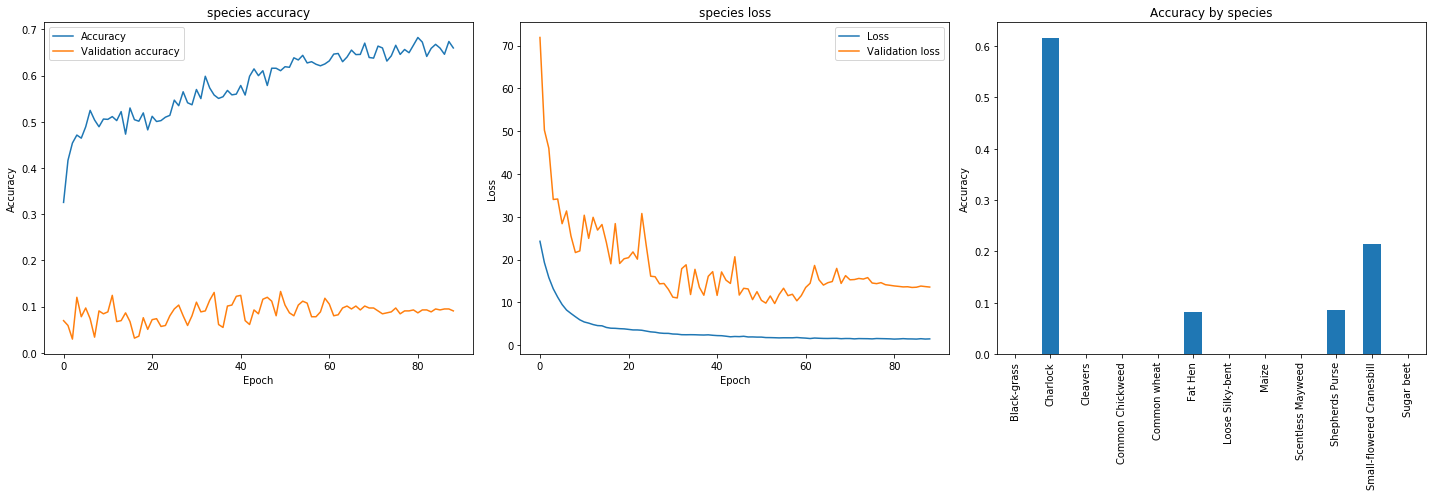

Classification report
                           precision    recall  f1-score   support

              Black-grass       1.00      0.00      0.00        26
                 Charlock       0.10      0.62      0.18        39
                 Cleavers       0.00      0.00      0.00        24
         Common Chickweed       0.00      0.00      0.00        63
             Common wheat       1.00      0.00      0.00        19
                  Fat Hen       0.16      0.08      0.11        49
         Loose Silky-bent       0.00      0.00      0.00        66
                    Maize       0.00      0.00      0.00        26
        Scentless Mayweed       1.00      0.00      0.00        55
          Shepherds Purse       0.14      0.22      0.17        23
Small-flowered Cranesbill       0.06      0.21      0.10        42
               Sugar beet       1.00      0.00      0.00        43

                 accuracy                           0.09       475
                macro avg       0.37  

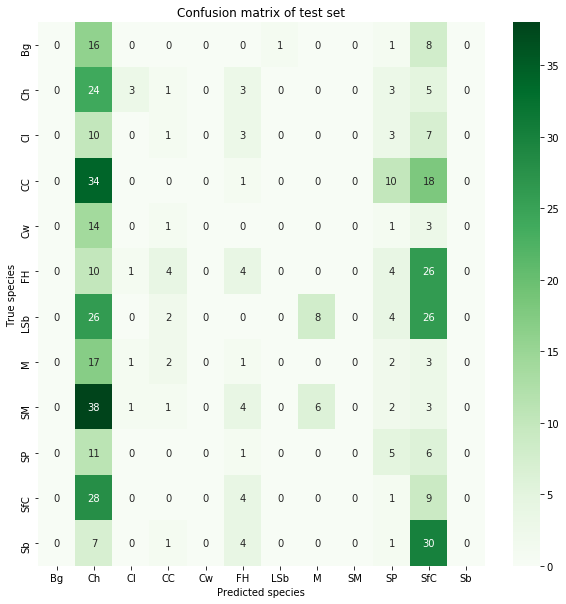

In [26]:
model.eval_model(test_X, test_Y, "species")

# 6. Generate prediction file
This section generates the prediction file to upload for Kaggle.

In [0]:
def load_test():
    test = []
    files = os.listdir(TEST_DATASET_FOLDER)
    for file in tqdm(files, total = len(files)):
        test.append([f'{TEST_DATASET_FOLDER}/{file}', file])
    
    test_df = pd.DataFrame(test, columns=['filepath', 'file'])
    
    return test_df

def generate_prediction_file(model, image_width, image_height, preprocess_function = segment_plant):
    test_df = load_test()
    test_images = load_images(test_df['filepath'], image_width, image_height, preprocess_function)
    
    species_name_predictions = model.predict_species_name(np.stack(test_images))
    file_output = np.column_stack((test_df['file'], species_name_predictions))
    
    file_df = pd.DataFrame(file_output, columns = ['file', 'species'])
    file_df.to_csv("submission.csv", index = False, index_label = False)
    
    return file_df

In [28]:
file_df = generate_prediction_file(model, IMAGE_WIDTH, IMAGE_HEIGHT)
file_df.head(10)

100%|██████████| 794/794 [05:55<00:00,  1.97it/s]


794/794 [==============================] - 4s 5ms/sample


,file,species
0,f48916a8c.png,Small-flowered Cranesbill
1,9cce7328c.png,Maize
2,c5e419015.png,Shepherds Purse
3,a55d26a4c.png,Charlock
4,00ef713a8.png,Small-flowered Cranesbill
5,d2fd9df40.png,Charlock
6,29f49cd0b.png,Shepherds Purse
7,b6a3f7876.png,Charlock
8,9d79a1f0c.png,Charlock
9,d09d24c58.png,Small-flowered Cranesbill


## Learnings

1. Skimage could not handle the images loading with 16 GB RAM limit so OpenCV was used instead.
2. t-SNE improve after applying segmentation and masking over the images, but still cannot cluster correctly on lower dimensions.
3. Tensorflow and keras libraries were upgraded after migrating from Kaggle to Google Colab. Kaggle does not have unlimited GPU usage anymore.

# Links

This are some papers and links use during the exercise resolution:

- [Deep Learning using Linear Support Vector Machines](https://arxiv.org/pdf/1306.0239.pdf)
- [A New Design Based-SVM of the CNN Classifier Architecture with Dropout for Offline Arabic Handwritten Recognition](https://www.sciencedirect.com/science/article/pii/S1877050916309991)
- [Transfer learning from pre-trained models](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)
- [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)
- [Regularization and Optimization strategies in Deep Convolutional Neural Network](https://arxiv.org/pdf/1712.04711.pdf)
- [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
- [Revisiting small batch training for deep neural networks](https://arxiv.org/pdf/1804.07612.pdf)